In [4]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from os.path import join
import json
from os import environ, makedirs
from pathlib import Path
from cartopy.geodesic import Geodesic

In [5]:
input_folder = Path(environ.get(
    'CROSSCOMPUTE_INPUT_FOLDER','tests/standard/input'))
output_folder = Path(environ.get(
    'CROSSCOMPUTE_OUTPUT_FOLDER', 'tests/standard/output'))
try:
    makedirs(output_folder)
except OSError:
    pass

In [15]:
with open(input_folder/'variables.dictionary') as file:
    user_input=json.load(file)

58.254

In [ ]:
# data for the coordinates
try:
    coordinates= (
        pl.scan_csv(input_folder / "coordinates.csv").select(
        pl.col("Latitude").alias("Lat"),
        pl.col("Longitude").alias("Lon")).filter(
        ~((pl.col('Lat').is_null()) & (pl.col('Lat') < -90) | (pl.col('Lat') > 90)),
        ~((pl.col('Lon').is_null()) & (pl.col('Lon') < -180) | (pl.col('Lon') > 180))).collect().to_numpy())
except ValueError as e:
    print("validation Error{e}")

In [18]:
# Creating a function to convert degrees to radius
def degToRad(degrees):
    return degrees*(np.pi /180)
# Global variable Earth distance in KM
R=6371
#Create a function to calculate the distance
def dist(lat1, long1, lat2, long2):
    # getting the latitude difference degree
    d_lat=degToRad(lat2-lat1)
    
    # getting the longitude difference degree
    d_long=degToRad(long2-long1)
    # Applying Haversine formula for calculating the distance of coordinates
    a=np.sin(d_lat/2)**2 + np.cos(degToRad(lat1)) * np.cos(degToRad(lat2)) * np.sin(d_long/2)**2
    # a=np.clip(a,0,1) # for safety// not needed at the moment
    C=2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * C

In [ ]:
with open (join(output_folder,'Coordinates_Table.json'),'w') as file:
    json.dump({
    'columns':['Latitude', 'Longitude'], 'data':coordinates.tolist()}, file)

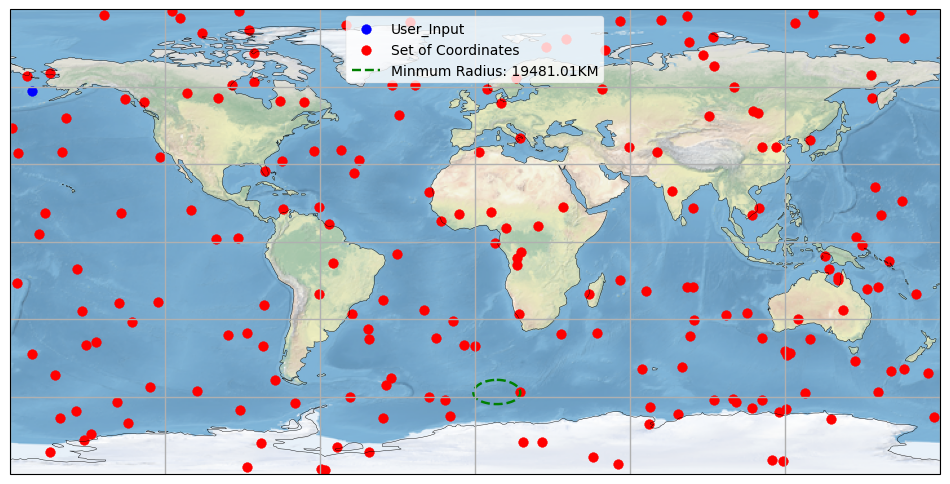

In [23]:
plt.style.use('seaborn-v0_8-notebook')

def mappingCoordinates(user_lat, user_lon):
    distances=[dist(user_lat, user_lon, lat, long) for lat, long in coordinates]
    # Minimum radius == the maximum distance 
    radius=max(distances)
    # Visualizing the coverage
    fig, ax=plt.subplots(figsize=(12,8), subplot_kw={"projection":ccrs.PlateCarree()})
    ax.stock_img()
    ax.coastlines()

    ax.scatter(user_lon, user_lat ,c='blue', label="User_Input", transform=ccrs.Geodetic())
    ax.scatter(coordinates[:,1],coordinates[:,0], c="red",label="Set of Coordinates", transform=ccrs.Geodetic())
    # Geodesic expects the radius in meters
    circle=Geodesic().circle(lat=user_lat, lon=user_lon, radius=radius*1000, n_samples=360)
    c_lon, c_lat=zip(*circle)
    ax.plot(c_lon, c_lat, 'g--',transform=ccrs.Geodetic(), label=f"Minmum Radius: {radius:.2f}KM")
    ax.gridlines()
    ax.legend()
    plt.savefig(output_folder/'CoordinateMap.png', dpi=300)

mappingCoordinates(user_input['Lat'], user_input['Lon'])